# Heralded Preparation of Fock States

Author: Nicolás Quesada 

In this tutorial we study how to prepare the $n=1$ Fock state by heralding two-mode squeezed vacuum using photon-number-resolving detectors.
This idea goes back to at least the following paper:
"Experimental realization of a localized one-photon state" [Phys. Rev. Lett. *56*, 58 (1986)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.133601) by C. K. Hong and L. Mandel

In [18]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
from thewalrus.quantum import state_vector, density_matrix
from qutip import wigner, Qobj, wigner_cmap

/home/nicolas/Code/donotkillme/strawberryfields/strawberryfields/ops.py:2194: UserWarning: The shorthand 'Measure' has been deprecated, please use 'MeasureFock()' instead.


## Ideal preparation

Here we setup some basic parameters, like the value of the photon-number-resolving detectors we will use to herald and the amount of squeezing to use.

In [19]:
n = 1
r = np.arcsinh(np.sqrt(n))

Now we setup a 2-mode quantum circuit in strawberryfields and obtain the covariance matrix and vector of means of the Gaussian state

In [20]:
nmodes = 2
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    S2gate(r)|q
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

We can now inspect the covariance matrix and vector of means

In [21]:
print(np.round(mu,10))
print(np.round(cov,10))

[0. 0. 0. 0.]
[[ 3.          2.82842712  0.         -0.        ]
 [ 2.82842712  3.         -0.          0.        ]
 [ 0.         -0.          3.         -2.82842712]
 [-0.          0.         -2.82842712  3.        ]]


We now use the walrus to obtain the Fock representation of the heralded Gaussian state when mode 1 is heralded in the value $n=1$ in the variable `psi`. We also calculate the probability of success in heralding in the variable `p_psi`

In [22]:
cutoff = 20
psi = state_vector(mu, cov, post_select={1:n}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi/p_psi

We now plot the photon-number distribution of the Heralded state. Note that the state is exactly a Fock state with a single photon

The probability of successful heralding is  0.25


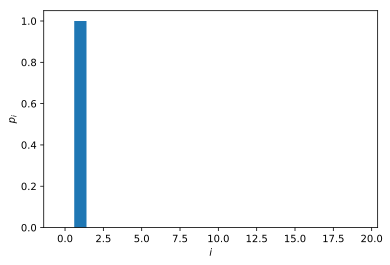

In [23]:
plt.bar(np.arange(cutoff),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")
print("The probability of successful heralding is ", np.round(p_psi**2,5))

We can now plot the Wigner function of the heralded state

Text(0.5, 1.0, 'Wigner function of the heralded state')

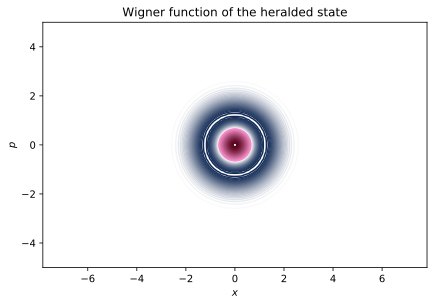

In [8]:
grid = 100
xvec = np.linspace(-5,5,grid)
W = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(W)
plt.contour(xvec,xvec, W, 100, cmap=wmap)
plt.axis('equal')
plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$p$")
plt.title("Wigner function of the heralded state")

and a cut of the Wigner function along $x=0$

Text(0.5, 0, 'p')

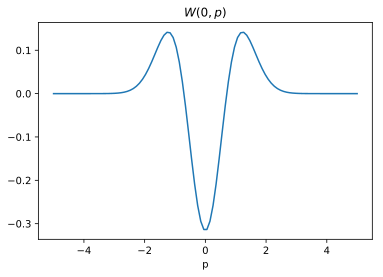

In [9]:
plt.plot(xvec, W[:,grid//2])
plt.title(r"$W(0,p)$")
plt.xlabel(r"p")

## Adding Loss

We can now study what happens when loss in the heralding arm is increased. We will add loss in the heralding arm by varying the efficiency of the detector from $\eta = 50\%$ to $\eta = 100\%$ (ideal operation).

In [10]:
eta_vals = np.arange(1.,0.5,-0.05)
fidelities = np.zeros_like(eta_vals)
success_p = np.zeros_like(eta_vals)
nmodes = 2
for i,eta in enumerate(eta_vals):
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")
    with prog.context as q:
        S2gate(r)|q
        LossChannel(eta)|q[1]
    state = eng.run(prog).state
    mu = state.means()
    cov = state.cov()
    rho = density_matrix(mu, cov, post_select={1:n}, normalize=False, cutoff=cutoff)
    success_p[i] = np.real_if_close(np.trace(rho))
    fidelities[i] = np.real_if_close(psi.conj() @ rho @ psi/success_p[i])

We now plot the probability of success of the Heralding scheme as a function of the transmission

Text(0, 0.5, 'Success prob.')

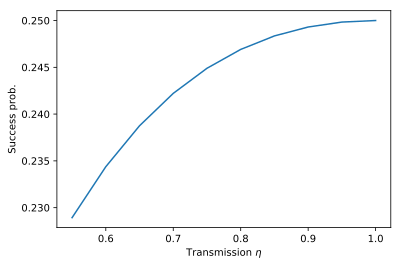

In [11]:
plt.plot(eta_vals, success_p)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Success prob.")

and similarly study the fidelity of the heralded state with respect to the ideal (lossless) state

Text(0, 0.5, 'Fidelity with ideal state')

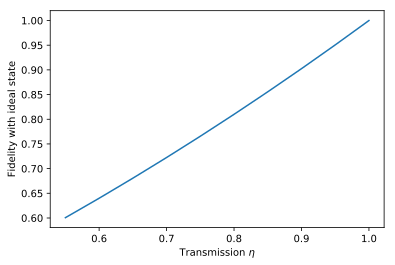

In [26]:
plt.plot(eta_vals, fidelities)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Fidelity with ideal state")

Now we plot the Wigner function of the heralded state for $\eta = 50\%$

eta=0.55


Text(0.5, 1.0, 'Wigner function of the heralded state with loss $\\eta=$0.55')

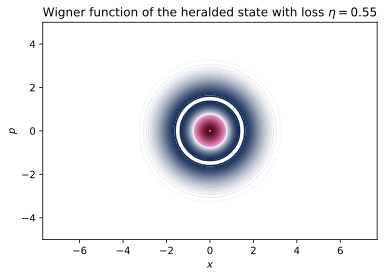

In [27]:
print("eta="+str(np.round(eta,4)))
grid = 100
xvec = np.linspace(-5,5,grid)
W = wigner(Qobj(rho/np.trace(rho)), xvec, xvec)
wmap = wigner_cmap(W)
plt.contour(xvec,xvec, W, 100, cmap=wmap)
plt.axis('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$p$")
plt.title(r"Wigner function of the heralded state with loss $\eta=$"+str(np.round(eta,4)))

and also a cut of the Wigner along $x=0$

Text(0.5, 0, '$p$')

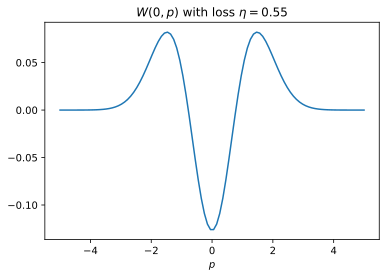

In [14]:
plt.plot(xvec, W[:,grid//2])
plt.title(r"$W(0,p)$ with loss $\eta=$"+str(np.round(eta,4)))
plt.xlabel(r"$p$")